In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import Input, layers
from tensorflow.keras import activations
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras import backend as k
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

# Deutch - English

## Training set 

In [2]:
# corpus_scor = "C:/Users/pc/OneDrive - NOVAIMS/2º Semestre 2021/Text Mining/Project/Project laser embeddings/corpus/de-en/scores.csv"
# corpus_path_ref = "C:/Users/pc/OneDrive - NOVAIMS/2º Semestre 2021/Text Mining/Project/Project laser embeddings/corpus/de-en/laser.reference_embeds.npy"
# corpus_path_source = "C:/Users/pc/OneDrive - NOVAIMS/2º Semestre 2021/Text Mining/Project/Project laser embeddings/corpus/de-en/laser.source_embeds.npy"
# corpus_path_translation = "C:/Users/pc/OneDrive - NOVAIMS/2º Semestre 2021/Text Mining/Project/Project laser embeddings/corpus/de-en/laser.translation_embeds.npy"

In [3]:
corpus_scor = "C:/Users/m20200655/OneDrive - NOVAIMS/2º Semestre 2021/Text Mining/Project/Project laser embeddings/corpus/de-en/scores.csv"
corpus_path_ref = "C:/Users/m20200655/OneDrive - NOVAIMS/2º Semestre 2021/Text Mining/Project/Project laser embeddings/corpus/de-en/laser.reference_embeds.npy"
corpus_path_source = "C:/Users/m20200655/OneDrive - NOVAIMS/2º Semestre 2021/Text Mining/Project/Project laser embeddings/corpus/de-en/laser.source_embeds.npy"
corpus_path_translation = "C:/Users/m20200655/OneDrive - NOVAIMS/2º Semestre 2021/Text Mining/Project/Project laser embeddings/corpus/de-en/laser.translation_embeds.npy"

In [4]:
corpus_scores = pd.read_csv(corpus_scor)
corpus_reference = np.load(corpus_path_ref, mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')
corpus_source = np.load(corpus_path_source, mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')
corpus_translation = np.load(corpus_path_translation, mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')

In [10]:
corpus_scores.head()

,source,reference,translation,z-score,avg-score,annotators
0,"Ihr Zeitlupentempo maßen sie, als sie vor Spit...",Her timeless pace measures them when they equi...,Their slow speed was measured by researchers o...,-0.345024,76.0,1
1,"Er sagte, dass die Bereiche ruhige Treffpunkte...",He said the areas offer quiet meeting points b...,He said the spaces provided calm meeting point...,0.903800,97.5,2
2,Für die Geschäftsleute an der B 27 ist es nur ...,"For businessmen at the B 27, it's only a small...",This is only a small consolation for businesse...,0.700503,94.0,1
3,Diese Fähigkeit sei möglicherweise angeboren o...,This ability may be born or developed with gen...,"This ability may be innate, or may develop as ...",-1.256572,51.5,2
4,Weil sie Wassertemperaturen um die sechs Grad ...,Because they prefer water temperatures around ...,They generally only come to the surface in win...,0.293909,87.0,2


In [5]:
# [h; r; h s; h  r; |h − s|; |h − r|] 

# Dot product Translation + source
h_dot_s = np.dot(corpus_translation,corpus_source.T)

# dot product tranlation reference
h_dot_r = np.dot(corpus_translation,corpus_reference.T)

# Absolute difference translation-source
abs_h_s = np.absolute(corpus_translation - corpus_source)
abs_h_s.shape

# Absolute difference translation-reference
abs_h_r = np.absolute(corpus_translation - corpus_reference)
abs_h_r.shape

train = np.concatenate((corpus_translation,corpus_reference,h_dot_s,h_dot_r,abs_h_s,abs_h_r),axis=1)

little_train = np.concatenate((corpus_translation,corpus_reference,abs_h_r),axis=1)

print(h_dot_s.shape,h_dot_r.shape)
print(abs_h_s.shape,abs_h_r.shape)
print(train.shape,little_train.shape )

(21704, 21704) (21704, 21704)
(21704, 1024) (21704, 1024)
(21704, 47504) (21704, 3072)


In [6]:
test_scor = "C:/Users/m20200655/OneDrive - NOVAIMS/2º Semestre 2021/Text Mining/Project/Project laser embeddings/testset/de-en/scores.csv"
testset_path_ref = "C:/Users/m20200655/OneDrive - NOVAIMS/2º Semestre 2021/Text Mining/Project/Project laser embeddings/testset/de-en/laser.reference_embeds.npy"
testset_path_source = "C:/Users/m20200655/OneDrive - NOVAIMS/2º Semestre 2021/Text Mining/Project/Project laser embeddings/testset/de-en/laser.source_embeds.npy"
testset_path_translation = "C:/Users/m20200655/OneDrive - NOVAIMS/2º Semestre 2021/Text Mining/Project/Project laser embeddings/testset/de-en/laser.translation_embeds.npy"

In [8]:
test_score = pd.read_csv(test_scor)
testset_reference = np.load(testset_path_ref, mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')
testset_source = np.load(testset_path_source, mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')
testset_translation = np.load(testset_path_translation, mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')

In [9]:
test_score.head()

,source,reference,translation
0,Das Publikum ist fast gleichmäßig zwischen Sch...,The audience is almost evenly split between bl...,The audience is almost evenly split between bl...
1,Du kannst ihre Energie durch den Bildschirm sp...,"You can feel their energy through the screen. """"","You can feel her energy through the screen."""
2,"Da die Adresse unbekannt ist, wird die Mithilf...","As the address is unknown, the help of the pop...","As the address is unknown, the assistance of t..."
3,"Arsenal-Manager Arsene Wenger, dessen Verein i...","Arsenal manager Arsene Wenger, whose club is o...","Arsenal manager Arsene Wenger, whose club is o..."
4,Landwirtschaftsminister im Interview - Wie sch...,Agriculture Minister in the interview - How do...,Minister of Agriculture in interview – How do ...


In [8]:
testset_reference.shape

(28404, 1024)

In [9]:
# [h; r; h s; h  r; |h − s|; |h − r|] 

# Dot product Translation + source
h_dot_s = np.dot(testset_translation,testset_source.T)

# dot product tranlation reference
h_dot_r = np.dot(testset_translation,testset_reference.T)

# Absolute difference translation-source
abs_h_s = np.absolute(testset_translation - testset_source)
abs_h_s.shape

# Absolute difference translation-reference
abs_h_r = np.absolute(testset_translation - testset_reference)
abs_h_r.shape

test = np.concatenate((testset_translation,testset_reference,h_dot_s,h_dot_r,abs_h_s,abs_h_r),axis=1)

little_test = np.concatenate((testset_translation,testset_reference,abs_h_r),axis=1)

print(h_dot_s.shape,h_dot_r.shape)
print(abs_h_s.shape,abs_h_r.shape)
print(test.shape,little_test.shape )

(28404, 28404) (28404, 28404)
(28404, 1024) (28404, 1024)
(28404, 60904) (28404, 3072)


# Simple feed forward network

<!-- # LSTM
## Text Classification with RNN - bi-directional 
https://www.tensorflow.org/tutorials/text/text_classification_rnn -->

In [10]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

In [11]:
reference_labels = np.array(corpus_scores['z-score'])
reference_labels.shape

(21704,)

In [12]:
X = little_train
X.shape

(21704, 3072)

In [13]:
Y = reference_labels
Y.shape

(21704,)

In [14]:
X_train, X_val, Y_train, Y_val = train_test_split(X,Y, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_val.shape,Y_val.shape)

(17363, 3072) (17363,)
(4341, 3072) (4341,)


In [15]:
# # X_train = X_train.reshape(-1,1,1024)
# # X_val = X_val.reshape(-1,1,1024)
# # Y_train = Y_train.reshape(-1,1,1)
# # Y_val = Y_val.reshape(-1,1,1)
# # print(X_train.shape,Y_train.shape)
# # print(X_val.shape,Y_val.shape)

# X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],1)

# # Y_train=Y_train.reshape(Y_train.shape[0],Y_train.shape[1],1)

# X_val=X_val.reshape(X_val.shape[0],X_val.shape[1],1)

# Y_val=Y_val.reshape(Y_val.shape[0],Y_val.shape[1],1)

# print(X_train.shape,Y_train.shape)
# print(X_val.shape,Y_val.shape)

In [16]:
# Callbacks
batch_size =10248

early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=25)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.0001,
                              patience=5, min_lr=0.0001)

mcp = ModelCheckpoint('model.h5', 
                      monitor='val_loss', verbose=1, 
                      save_best_only=True, save_weights_only=True)

In [17]:
# model with better results 
model = Sequential()
model.add(Dense(1024, input_shape=(X_train.shape[1],), activation = 'relu'))
# model.add(Dropout(0.1))
model.add(Dense(512, activation ='relu'))
model.add(Dropout(0.1))
model.add(Dense(256, activation ='relu'))
model.add(Dropout(0.1))
model.add(Dense(128, activation ='relu'))
model.add(Dense(1))

In [18]:
# # Callbacks

# early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.0001,
#                               patience=5, min_lr=0.00001)

# mcp = ModelCheckpoint('model.h5', 
#                       monitor='val_loss', verbose=0, 
#                       save_best_only=True, save_weights_only=True)

# batch_size = 14336

# model = Sequential()

# model.add(Dense(2048, input_shape=(X_train.shape[1],), activation = 'relu'))
# # model.add(Dropout(0.1))
# model.add(Dense(1024, activation ='relu'))
# model.add(Dropout(0.1))
# model.add(Dense(512, activation ='relu'))
# model.add(Dropout(0.1))
# model.add(Dense(256, activation ='relu'))
# model.add(Dropout(0.1))
# model.add(Dense(128, activation ='relu'))
# model.add(Dense(1))

In [19]:
model.compile(loss=tf.keras.losses.MSE,
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              metrics=['mae'])

In [20]:
print("Fit model on training data")
history = model.fit(
    X_train,
    Y_train,
    epochs=150, # previous 1000
    batch_size =batch_size,# previous one 8192 #4096 - best score so far
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(X_val, Y_val),verbose =0, callbacks=[early_stop,reduce_lr]) # validation_split=0.2,mcp

Fit model on training data


(0.0, 1.6558239102363586)

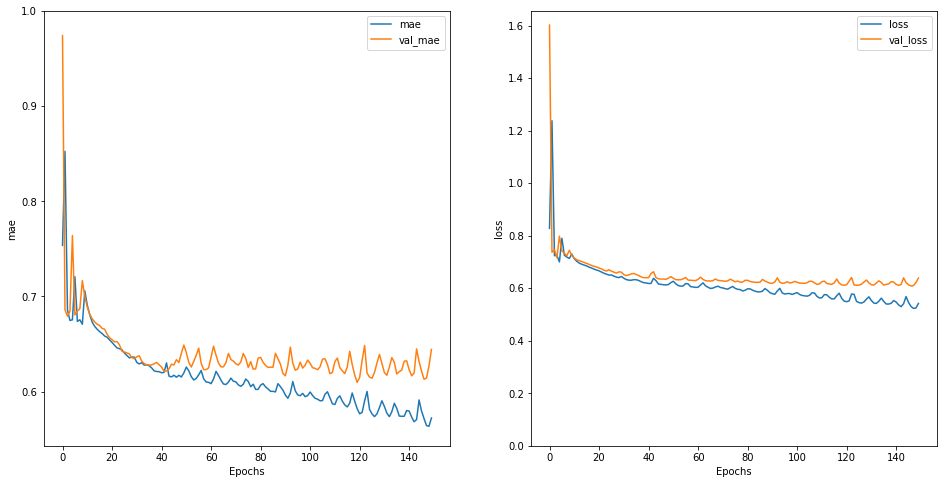

In [21]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'mae')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [22]:
# Evaluate the model on the test data using `evaluate`

print("Evaluate on test data")
results = model.evaluate(X_val, Y_val, batch_size=batch_size)
print("test loss, test acc:", results)

Evaluate on test data
1/1 [==============================] - 0s 500us/step - loss: 0.6387 - mae: 0.6443
test loss, test acc: [0.638748049736023, 0.6443251967430115]


# predicting @ test data

In [23]:
# Generate predictions (probabilities -- the output of the last layer) on new data using `predict`
print("Generate predictions samples")
predictions = model.predict(little_test)
print("predictions shape:", predictions.shape)

Generate predictions samples
predictions shape: (28404, 1)


In [24]:
test_score['lp'] = 'de-en'
test_score['score'] = predictions
test_score.head()

,source,reference,translation,lp,score
0,Das Publikum ist fast gleichmäßig zwischen Sch...,The audience is almost evenly split between bl...,The audience is almost evenly split between bl...,de-en,0.718034
1,Du kannst ihre Energie durch den Bildschirm sp...,"You can feel their energy through the screen. """"","You can feel her energy through the screen.""",de-en,0.466494
2,"Da die Adresse unbekannt ist, wird die Mithilf...","As the address is unknown, the help of the pop...","As the address is unknown, the assistance of t...",de-en,0.787594
3,"Arsenal-Manager Arsene Wenger, dessen Verein i...","Arsenal manager Arsene Wenger, whose club is o...","Arsenal manager Arsene Wenger, whose club is o...",de-en,0.770549
4,Landwirtschaftsminister im Interview - Wie sch...,Agriculture Minister in the interview - How do...,Minister of Agriculture in interview – How do ...,de-en,-0.312158


In [25]:
test_score.to_csv('de-en_predictions.csv')

# checking corr @ X_val

In [26]:
# Generate predictions (probabilities -- the output of the last layer) on new data using `predict`
print("Generate predictions samples")
predictions = model.predict(X_val)
print("predictions shape:", predictions.shape)

Generate predictions samples
predictions shape: (4341, 1)


In [27]:
corr_data = pd.DataFrame([Y_val]).T
pred = pd.DataFrame(predictions)
corr_data['predictions'] = pred
corr_data.columns = ['z-score','predictions']
corr_data.corr()

,z-score,predictions
z-score,1.000000,0.428317
predictions,0.428317,1.000000
